In [1]:
import pandas as pd
import wandb
from tqdm.notebook import tqdm
import pickle
import torch
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import MaxNLocator
from seaborn import heatmap
from gpytorch.kernels import ScaleKernel, RBFKernel
from gp.soft_gp.soft_gp import SoftGP

from data.get_uci import all_datasets
from analysis.util import fetch, init_uci_dict, get_uci_info

In [2]:
filters = {
    "group": "benchmark"
}
raw = fetch("softki", filters)

100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


In [8]:
uci_info = get_uci_info()

In [9]:
uci_dict = {}
for exp in raw:
    model = exp.config["model.name"]
    dataset = exp.config["dataset.name"]
    dtype = exp.config["model.dtype"]
    seed = exp.config["training.seed"]
    train_frac = float(exp.config["dataset.train_frac"])
    uci_dict[(dataset, seed, model)] = exp.history

print(uci_dict.keys())

dict_keys([('houseelectric', 92357, 'sv-gp'), ('houseelectric', 92357, 'svi-gp'), ('houseelectric', 92357, 'soft-gp'), ('buzz', 92357, 'sv-gp'), ('buzz', 92357, 'svi-gp'), ('buzz', 92357, 'soft-gp'), ('song', 92357, 'sv-gp'), ('song', 92357, 'svi-gp'), ('elevators', 92357, 'exact'), ('elevators', 8830, 'exact'), ('elevators', 6535, 'exact'), ('pol', 92357, 'exact'), ('pol', 8830, 'exact'), ('pol', 6535, 'exact'), ('song', 92357, 'soft-gp'), ('3droad', 92357, 'sv-gp'), ('3droad', 92357, 'svi-gp'), ('3droad', 92357, 'soft-gp'), ('keggundirected', 92357, 'sv-gp'), ('keggundirected', 92357, 'svi-gp'), ('keggundirected', 92357, 'soft-gp'), ('slice', 92357, 'sv-gp'), ('slice', 92357, 'svi-gp'), ('slice', 92357, 'soft-gp'), ('keggdirected', 92357, 'sv-gp'), ('keggdirected', 92357, 'svi-gp'), ('keggdirected', 92357, 'soft-gp'), ('protein', 92357, 'sv-gp'), ('protein', 92357, 'svi-gp'), ('protein', 92357, 'soft-gp'), ('kin40k', 92357, 'sv-gp'), ('kin40k', 92357, 'svi-gp'), ('kin40k', 92357, 'so

In [10]:
seeds = [6535, 8830, 92357]
num_inducings = [512]
tmp = {
    "N": [int(np.floor(N * 0.9)) for _, N, _, _ in uci_info],
    "D": [D for _, _, D, _ in uci_info],
}
models = ["soft-gp"]

for seed in seeds:
    for model in models:
        xs = []
        ts = []
        ls = []
        for dataset, _, _, _ in uci_info:
            try:
                xs += [uci_dict[(dataset, seed, model)]["test_rmse"][49]]
                ts += [np.array(uci_dict[(dataset, seed, model)]["epoch_time"][49]).mean()]
                ls += [uci_dict[(dataset, seed, model)]["lengthscale"][49]]
            except Exception as e:
                xs += [np.nan]
                ts += [np.nan]
                ls += [np.nan]
                print("Exception", e, model, dataset)

        tmp[f"{model}-{seed}"] = xs
        tmp[f"time-{model}-{seed}"] = ts
        tmp[f"time-{model}-{seed}"] = ts
df = pd.DataFrame(data=tmp)
df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
df

,N,D,soft-gp-6535,time-soft-gp-6535,soft-gp-8830,time-soft-gp-8830,soft-gp-92357,time-soft-gp-92357
Pol,13500,26,0.189090,0.997318,0.201633,0.968105,0.194142,0.970340
Elevators,14939,18,0.391091,1.042252,0.397603,1.001670,0.378056,1.048295
Bike,15641,17,0.207343,1.023231,0.207698,1.005835,0.197691,1.109241
Kin40k,36000,8,0.242823,2.490466,0.228539,2.490607,0.240351,2.452027
Protein,41157,9,0.656468,2.671560,0.637237,2.596986,0.652667,2.694561
Keggdirected,43944,20,0.078806,2.874196,0.078002,2.824960,0.086797,2.824457
Slice,48150,385,0.051143,3.252744,0.046230,3.191933,0.049958,3.193140
Keggundirected,57247,27,0.116864,3.702446,0.110840,3.632767,0.118425,3.545317
3droad,391386,3,0.605115,24.244727,0.605536,24.399555,0.605276,24.127853
Song,270000,90,0.797246,17.626724,0.791343,17.304378,0.788976,17.325230


In [40]:
api = wandb.Api()
for exp in tqdm(raw):
    run = api.run(f'bogp/softki/{exp.run.id}')
    if exp.config["training.seed"] == 6535:
        for artifact in run.logged_artifacts():
            print(artifact.name)
            artifact.download(root=f"visualize/{artifact.name}/")

  0%|          | 0/150 [00:00<?, ?it/s]

run-ofjbvfwl-history:v0


wandb:   1 of 1 files downloaded.  


run-f6nr8g8q-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-34o0ufk6-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-3a882lom-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-j3ny7hnl-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-3nswxzn0-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-6tvpewxs-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-mkg4burj-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-t76ne2fd-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-xdzmvl9h-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-ejh6724c-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-slgs188l-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-npjd4v39-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-in3ebpnx-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-qhqa53np-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-6zmjg57s-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-fiibw5ea-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-yw1kgeo1-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-5mlu3alw-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-a68bnqaa-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-ab17rlwh-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-61o6kzj2-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-sr6jw5wz-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-h8t6nppb-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-ilp7svmj-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-r65ynsjq-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-fncbzooy-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-wl8jrapi-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-o2wkcknl-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-jbss9whz-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-xfduoi4x-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-wg259ert-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-n4ry0k2j-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-ga4olbbv-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-15c12m8q-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-jesye31o-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-wuj4gstj-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-ryqfi4ju-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-qlfkvcwh-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-2lh72oct-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-nqt8myl7-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-zdcyj6fq-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-9se5wc70-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-d4jnd0ec-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-pt60tnya-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-xfl042i4-history:v0


wandb:   1 of 1 files downloaded.  


In [41]:
def load(dataset, v):
    kernels = []
    softgps = []
    K_zzs = []
    epochs = [0, 10, 20, 30, 40, 50]
    # epochs = [0, 20, 40, 60, 80, 99]
    for epoch, epoch_exact in zip([0, 10, 20, 30, 40, 49], epochs):
        K_zz = np.load(f"visualize/K_zz_softgp_{dataset}_512_1024_0.001_6535_{epoch}:{v}/K_zz.npy")
        # W_xz = np.load(f"artifacts/W_xz_softgp_{dataset}_512_1024_0.001_6535_{epoch}:v0/W_xz.npy")
        z = torch.tensor(np.load(f"visualize/inducing_points_softgp_{dataset}_512_1024_0.001_6535_{epoch}:{v}/array.npy"), dtype=torch.float32)
        print(z.shape)
        l = uci_dict[(dataset, 6535, "soft-gp")]["lengthscale"][epoch]
        s = uci_dict[(dataset, 6535, "soft-gp")]["outputscale"][epoch]
        print("l", l, "s", s)
        skernel = RBFKernel()
        skernel.lengthscale = l
        softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)
        softgp.kernel.base_kernel.outputscale = s

        kernel = ScaleKernel(RBFKernel())
        l = uci_dict[(dataset, 6535, "exact")]["lengthscale"][epoch_exact]
        s = uci_dict[(dataset, 6535, "exact")]["outputscale"][epoch_exact]
        kernel.base_kernel.lengthscale = l
        kernel.outputscale = s
        print("l", l, "s", s)
        print(K_zz.shape, z.shape)
        kernels += [kernel]
        softgps += [softgp]
        K_zzs += [K_zz]

    return kernels, softgps, K_zzs

# kernels, softgps, K_zzs = load("elevators")

In [42]:
from data.get_uci import (
        PoleteleDataset,
        ElevatorsDataset,
        BikeDataset,
        Kin40KDataset,
        ProteinDataset,
        KeggDirectedDataset,
        CTSlicesDataset,
        KeggUndirectedDataset,
        RoadDataset,
        SongDataset,
        BuzzDataset,
        HouseElectricDataset,
    )
from gp.util import flatten_dataset, split_dataset
np.random.seed(6535)
torch.manual_seed(6535)

In [43]:
kernels, softgps, K_zzs = load("elevators", "v0")

my_dataset = ElevatorsDataset(f"../data/uci_datasets/uci_datasets/elevators/data.csv")
# Generate splits
train_dataset, val_dataset, test_dataset = split_dataset(
    my_dataset,
    train_frac=0.9,
    val_frac=0.0
)
test_features, test_labels = flatten_dataset(test_dataset)
xs = test_features[0:64,:]

norms = []
with torch.no_grad():
    for idx, (kernel, softgp, K_zz) in enumerate(zip(kernels, softgps, K_zzs)):
        W_xz = softgp._interp(xs)
        Q_xx = W_xz @ K_zz @ W_xz.T
        K_xx = kernel(xs, xs).evaluate()
        norms += [torch.linalg.matrix_norm(K_xx - Q_xx, ord='fro') / torch.linalg.matrix_norm(K_xx, ord='fro')]

torch.Size([512, 18])
l 0.6262148022651672 s 0.771547794342041
Using softmax_interp
l 0.7443966865539551 s 0.6443967223167419
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.3111846446990967 s 1.3548169136047363
Using softmax_interp
l 1.3956273794174194 s 0.3008975684642792
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.4726392030715942 s 1.8219082355499268
Using softmax_interp
l 2.171576976776123 s 0.1761978417634964
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.522002935409546 s 2.2943809032440186
Using softmax_interp
l 2.5978963375091553 s 0.1609201580286026
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5375291109085083 s 2.769451379776001
Using softmax_interp
l 2.830556869506836 s 0.1962786465883255
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5390963554382324 s 3.1912169456481934
Using softmax_interp
l 3.1024153232574463 s 0.24466736614704132
(512, 512) torch.Size([512, 18])
SIZE (16599, 19)


/tmp/ipykernel_333983/2890792497.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)


  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_333983/1610380466.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


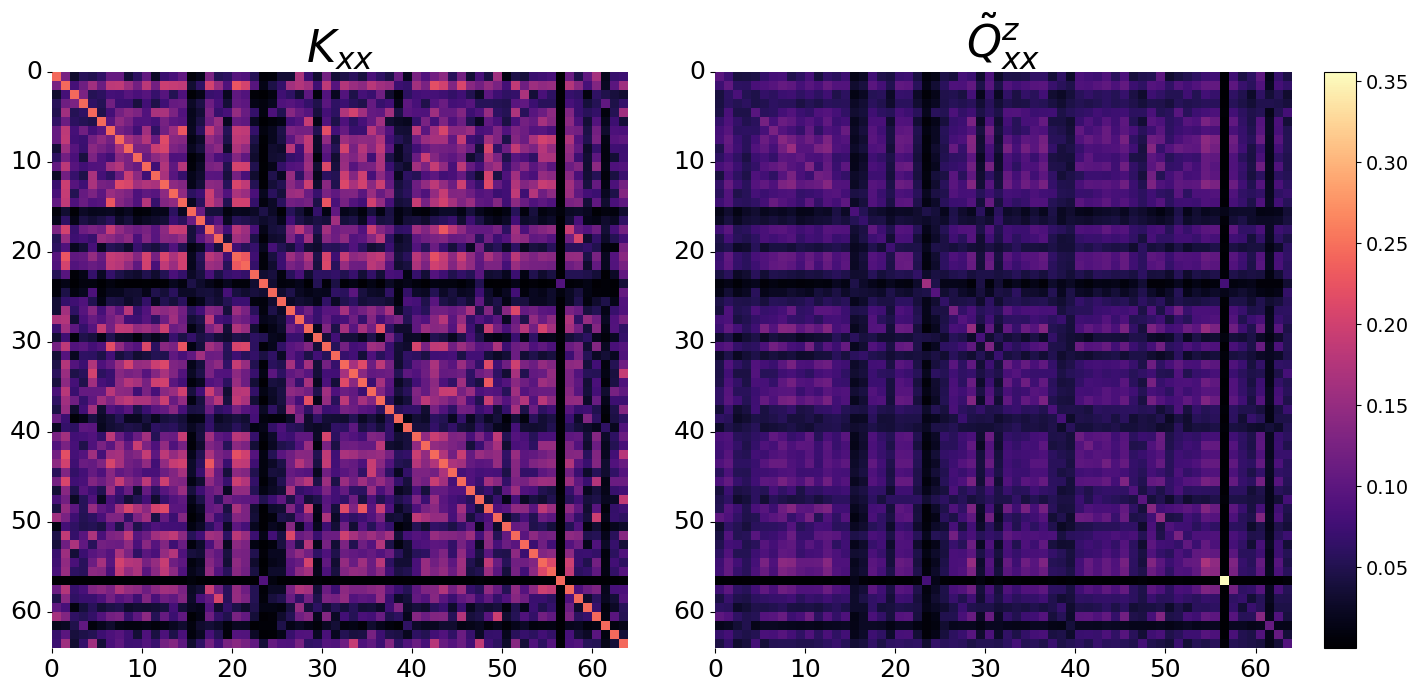

In [44]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_two_kernel_heatmaps_with_shared_colorbar(kernel1, kernel2, log_scale=False, cmap='viridis',
                                                  colorbar_shrink=0.76, title1=r"$K_{xx}$", title2=r"$\tilde{Q}_{xx}^z$", clip_low=1, clip_high=99.9):
    # Clip the outliers using percentiles to focus on the bulk of the data
    vmin = min(np.percentile(kernel1, clip_low), np.percentile(kernel2, clip_low))
    vmax = max(np.percentile(kernel1, clip_high), np.percentile(kernel2, clip_high))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.15})
    
    # First heatmap
    ax1.set_title(title1, fontsize=32)
    if log_scale:
        heatmap1 = sns.heatmap(kernel1, ax=ax1, cmap=cmap, cbar=False, norm=LogNorm(vmin=vmin, vmax=vmax))
    else:
        heatmap1 = sns.heatmap(kernel1, ax=ax1, cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)

    ax1.set_xticks(np.arange(0, kernel1.shape[1], 10))
    ax1.set_yticks(np.arange(0, kernel1.shape[0], 10))
    ax1.set_xticklabels(np.arange(0, kernel1.shape[1], 10), fontsize=18)
    ax1.set_yticklabels(np.arange(0, kernel1.shape[0], 10), fontsize=18)
    ax1.tick_params(axis='y', rotation=0)  # Ensure y-tick labels are not rotated
    ax1.set_aspect('equal')

    # Second heatmap
    ax2.set_title(title2, fontsize=32)
    if log_scale:
        heatmap2 = sns.heatmap(kernel2, ax=ax2, cmap=cmap, cbar=False, norm=LogNorm(vmin=vmin, vmax=vmax))
    else:
        heatmap2 = sns.heatmap(kernel2, ax=ax2, cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)

    ax2.set_xticks(np.arange(0, kernel2.shape[1], 10))
    ax2.set_yticks(np.arange(0, kernel2.shape[0], 10))
    ax2.set_xticklabels(np.arange(0, kernel2.shape[1], 10), fontsize=18)
    ax2.set_yticklabels(np.arange(0, kernel2.shape[0], 10), fontsize=18)
    ax2.tick_params(axis='y', rotation=0)  # Ensure y-tick labels are not rotated
    ax2.set_aspect('equal')

    # Create single colorbar aligned to a single heatmap size
    cbar_ax = fig.add_axes([0.92, ax1.get_position().y0, 0.02, ax1.get_position().height])  # Align height with first heatmap
    if log_scale:
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    colorbar = fig.colorbar(sm, cax=cbar_ax, shrink=colorbar_shrink)
    colorbar.ax.tick_params(labelsize=14)  # Set color bar font size

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
    plt.show()

# Example usage with K_xx and Q_xx
plot_two_kernel_heatmaps_with_shared_colorbar(K_xx, Q_xx, log_scale=False, cmap="magma", clip_low=0, clip_high=100)

Hi, I encourage, not using the clipping (clip_high=100) as its a touch shady. To get a new plot run the cell above 

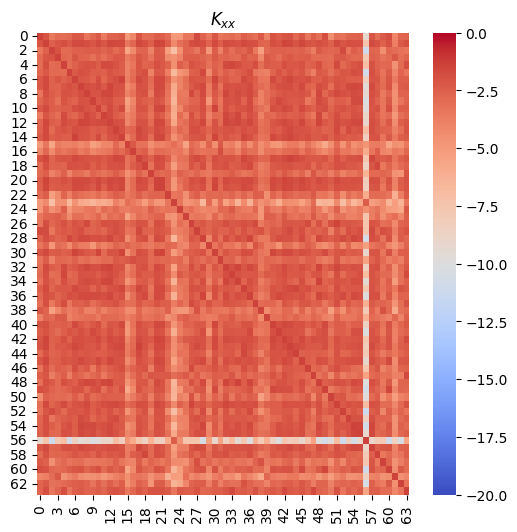

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$K_{xx}$")
heatmap(np.log(K_xx+1e-12), ax=axes, cmap='coolwarm', cbar=True, vmin=-20, vmax=0)
plt.savefig("compare/elevators_kxx.png", bbox_inches='tight')

[tensor(0.9877), tensor(0.8680), tensor(0.5568), tensor(0.3939), tensor(0.3428), tensor(0.4013)]


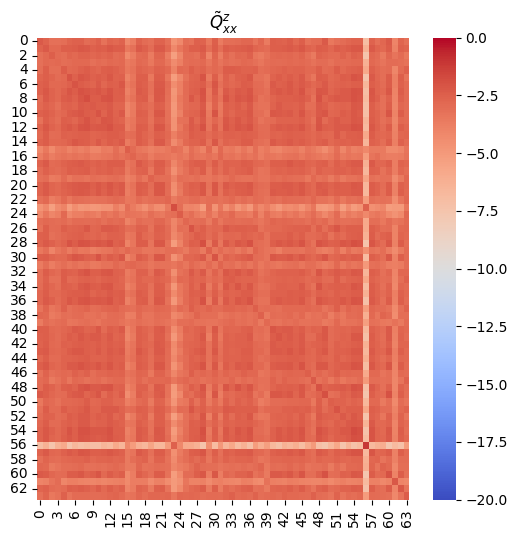

In [46]:
print(norms)
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$\tilde{Q}_{xx}^z$")
heatmap(np.log(Q_xx+1e-12), ax=axes, cmap='coolwarm', cbar=True, vmin=-20, vmax=0)
plt.savefig("compare/elevators_qxx.png", bbox_inches='tight')

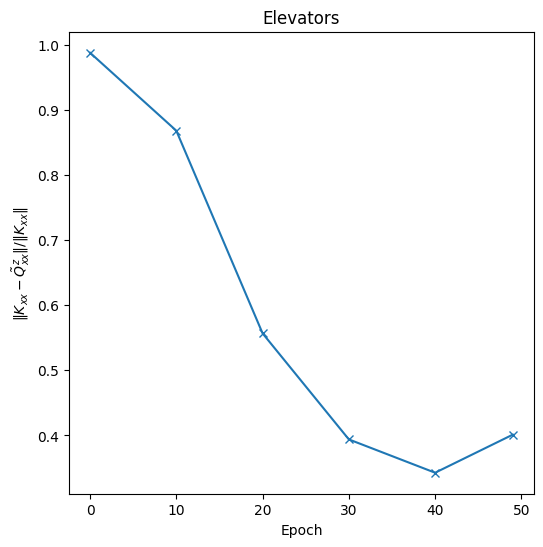

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plt.plot([0, 10, 20, 30, 40, 49], norms, marker="x")
plt.title("Elevators")
plt.xlabel("Epoch")
plt.ylabel(r"$\|K_{xx} - \tilde{Q}_{xx}^z\| / \|K_{xx}\|$");
plt.savefig("compare/elevators_kxx_qxx_norm.png", bbox_inches='tight')

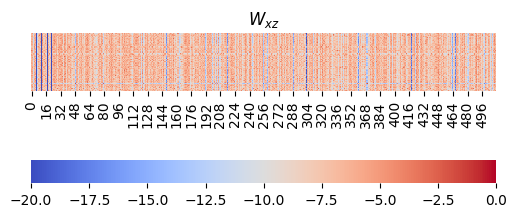

In [48]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$W_{xz}$")
axes.set_aspect('equal')
heatmap(np.log(W_xz+1e-12), ax=axes, cmap='coolwarm', cbar=True, cbar_kws={"orientation": "horizontal"}, yticklabels=False, vmin=-20, vmax=0)
plt.savefig("compare/elevators_Wxz.png", bbox_inches='tight')

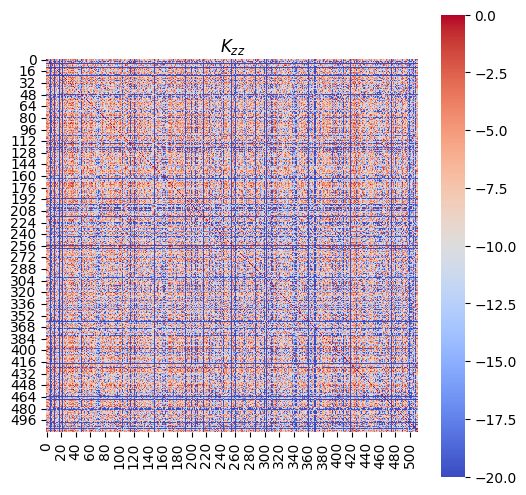

In [49]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$K_{zz}$")
axes.set_aspect('equal')
heatmap(np.log(K_zz+1e-12), ax=axes, cmap='coolwarm', cbar=True, vmin=-20, vmax=0)
plt.savefig("compare/elevators_Kzz.png", bbox_inches='tight')

In [50]:
kernels, softgps, K_zzs = load("pol", "v1")

my_dataset = PoleteleDataset(f"../data/uci_datasets/uci_datasets/pol/data.csv")
# Generate splits
train_dataset, val_dataset, test_dataset = split_dataset(
    my_dataset,
    train_frac=0.9,
    val_frac=0.0
)
test_features, test_labels = flatten_dataset(test_dataset)
xs = test_features[0:128,:]

norms = []
with torch.no_grad():
    for idx, (kernel, softgp, K_zz) in enumerate(zip(kernels, softgps, K_zzs)):
        W_xz = softgp._interp(xs)
        Q_xx = W_xz @ K_zz @ W_xz.T
        K_xx = kernel(xs, xs).evaluate()
        norms += [torch.linalg.matrix_norm(K_xx - Q_xx, ord='fro') / torch.linalg.matrix_norm(K_xx, ord='fro')]

torch.Size([512, 26])
l 0.6326251029968262 s 0.7651041746139526
Using softmax_interp
l 0.7443966865539551 s 0.6443967223167419
(512, 512) torch.Size([512, 26])
torch.Size([512, 26])
l 0.7479146718978882 s 1.5182552337646484
Using softmax_interp
l 1.3722423315048218 s 0.294388085603714
(512, 512) torch.Size([512, 26])
torch.Size([512, 26])
l 0.6321934461593628 s 2.272688865661621
Using softmax_interp
l 2.0252840518951416 s 0.1437268853187561
(512, 512) torch.Size([512, 26])
torch.Size([512, 26])
l 0.5387333631515503 s 2.967967987060547
Using softmax_interp
l 2.423990488052368 s 0.0937381237745285
(512, 512) torch.Size([512, 26])
torch.Size([512, 26])
l 0.45749902725219727 s 3.618978261947632
Using softmax_interp
l 2.5030202865600586 s 0.08585197478532791
(512, 512) torch.Size([512, 26])
torch.Size([512, 26])
l 0.3968324661254883 s 4.16295051574707
Using softmax_interp
l 2.3917202949523926 s 0.09627459943294525
(512, 512) torch.Size([512, 26])
SIZE (15000, 27)


/tmp/ipykernel_333983/2890792497.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)


  0%|          | 0/1 [00:00<?, ?it/s]

[tensor(0.9339), tensor(0.8086), tensor(0.8739), tensor(1.0420), tensor(1.3068), tensor(1.4998)]


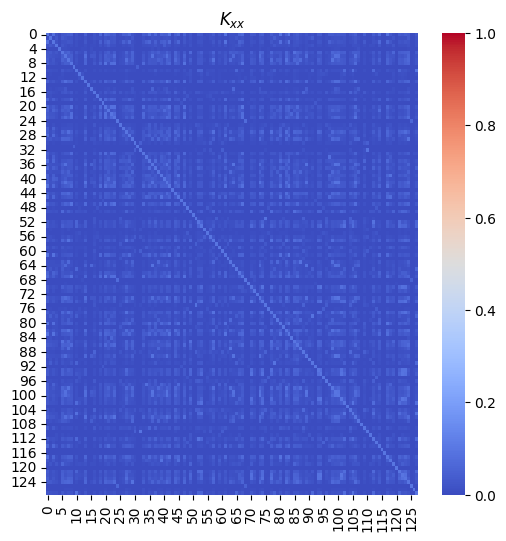

In [51]:
print(norms)
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$K_{xx}$")
heatmap(K_xx, ax=axes, cmap='coolwarm', cbar=True, vmin=0.0, vmax=1)
plt.savefig("compare/pol_kxx.png")

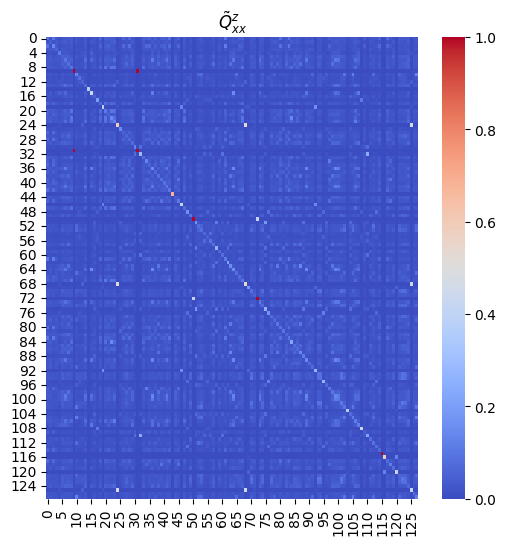

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$\tilde{Q}_{xx}^z$")
heatmap(Q_xx, ax=axes, cmap='coolwarm', cbar=True, vmin=0.0, vmax=1)
plt.savefig("compare/pol_qxx.png")